## Importing and Useful Functions

In [1]:
import os
import sys
from joblib import Parallel, delayed
from collections import defaultdict
from tqdm.autonotebook import tqdm
from tqdm_joblib import tqdm_joblib

os.environ["NUMBA_CUDA_DRIVER"] = "/usr/lib/wsl/lib/libcuda.so"

/tmp/ipykernel_108945/1957532836.py:5: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
path_to_repo = os.path.dirname(os.getcwd())
sys.path.insert(0, os.path.join(path_to_repo, "src"))

In [3]:
from mlpcourse.utils import *

In [4]:
import numpy as np
import pandas as pd
import cupy as cp
import cudf as cd

from cuml.ensemble import RandomForestRegressor
from cuml.metrics import mean_squared_error
from sklearn.cluster import AgglomerativeClustering

from matplotlib import pyplot as plt

In [5]:
def split_vals(df, n):
    return df[:n].copy(), df[n:].copy()


def rmse(y_gold, y_pred):
    return cp.sqrt(cp.mean((y_gold - y_pred) ** 2))


def print_score(m, X_train, y_train, X_valid, y_valid):
    print(f"RMSE on train set: {rmse(y_train, m.predict(X_train)):.4f}")
    print(f"RMSE on valid set: {rmse(y_valid, m.predict(X_valid)):.4f}")
    print(f"R^2 on train set: {m.score(X_train, y_train):.4f}")
    print(f"R^2 on valid set: {m.score(X_valid, y_valid):.4f}")
    return


def permutation_importance(model, X, y, baseline_mse, n_repeats=5, n_jobs=2):
    importances = cp.zeros((X.shape[1], n_repeats))

    # for i in tqdm(range(X.shape[1])):
    def compute_importance(i):
        local_importances = cp.zeros(n_repeats)

        for n in range(n_repeats):
            X_permuted = X.copy(deep=True)
            X_permuted.iloc[:, i] = (
                X_permuted.iloc[:, i].sample(frac=1).reset_index(drop=True)
            )

            permuted_predictions = model.predict(X_permuted)
            permuted_mse = mean_squared_error(y, permuted_predictions)

            local_importances[n] = permuted_mse - baseline_mse

        return local_importances

    with tqdm_joblib(tqdm(desc="Computing importances", total=X.shape[1])):
        results = Parallel(n_jobs=n_jobs)(
            delayed(compute_importance)(i) for i in range(X.shape[1])
        )

    for i, local_importance in enumerate(results):
        importances[i, :] = local_importance

    return importances.mean(axis=1).get(), importances.get()


def plot_importances(importances, sorted_idx, X_valid, title):
    plt.subplots(figsize=(12, 15))
    plt.boxplot(
        importances[sorted_idx].T, vert=False, tick_labels=X_valid.columns[sorted_idx]
    )
    plt.title(title)
    plt.show()


def rankdata(a):
    ivec = cp.argsort(a)
    svec = cp.argsort(ivec)
    return svec.astype(cp.float32)


def remove_redundant_features(df, threshold=0.2):
    # Remove constant columns
    df = df.loc[:, (df != df.iloc[0]).any().values_host]

    # Calculate Spearman correlation matrix
    num_cols = df.shape[1]
    corr = cp.zeros((num_cols, num_cols))

    cp_array = df.to_cupy()
    ranked_cp_array = cp.apply_along_axis(rankdata, axis=0, arr=cp_array)
    ranked_df = cd.DataFrame(ranked_cp_array, index=df.index, columns=df.columns)

    for i in range(num_cols):
        for j in range(i, num_cols):
            col1 = ranked_df.iloc[:, i].to_cupy()
            col2 = ranked_df.iloc[:, j].to_cupy()
            d = col1 - col2
            d_squared_sum = cp.sum(d**2)
            n = len(col1)
            spearman_corr = 1 - (6 * d_squared_sum) / (n * (n**2 - 1))
            corr[i, j] = spearman_corr
            corr[j, i] = spearman_corr
    corr = cp.round(corr)

    if cp.any(cp.isnan(corr)):
        raise ValueError(
            "Correlation matrix contains NaN values. Please check your data."
        )

    # Perform hierarchical clustering using sklearn, because the cuML version doesn't support 'distance_threshold'.
    # This has almost no impact on performance!
    clustering = AgglomerativeClustering(
        n_clusters=None, distance_threshold=threshold, linkage="average"
    )
    cluster_ids = clustering.fit_predict(1 - corr.get())
    cluster_id_to_feature_ids = defaultdict(list)
    for idx, cluster_id in enumerate(cluster_ids):
        cluster_id_to_feature_ids[cluster_id].append(idx)

    # Retain the first feature in each cluster
    selected_features = [df.columns[v[0]] for v in cluster_id_to_feature_ids.values()]
    return df[selected_features]

## Data Preparation

In [6]:
path_to_dataset = os.path.join(
    os.path.dirname(os.getcwd()), "data", "bulldozers", "bulldozers-raw"
)

df_raw = pd.read_feather(path_to_dataset)

df, y, _ = proc_df(df_raw, "SalePrice")

df = cd.DataFrame.from_pandas(df).astype(np.float32)
y = cp.asarray(y)


n_total = len(df)
n_valid = 12000
n_train = n_total - n_valid

X_train, X_valid = split_vals(df, n_train)
y_train, y_valid = split_vals(y, n_train)

## First Training

In [7]:
model = RandomForestRegressor(
    n_estimators=50,
    min_samples_split=10,
    max_features=0.5,
    random_state=42,
    bootstrap=True,
    max_samples=0.75,
    n_streams=1
)

model.fit(X_train, y_train)

RandomForestRegressor()

In [8]:
print_score(model, X_train, y_train, X_valid, y_valid)

RMSE on train set: 0.1965
RMSE on valid set: 0.2375
R^2 on train set: 0.9193
R^2 on valid set: 0.8992


In [9]:
baseline_predictions = model.predict(X_valid)
baseline_mse = mean_squared_error(y_valid, baseline_predictions)

importances_mean, importances = permutation_importance(
    model, X_valid, y_valid, baseline_mse
)

sorted_idx = cp.argsort(importances_mean)

Computing importances:   0%|          | 0/66 [00:00<?, ?it/s]

  0%|          | 0/66 [00:00<?, ?it/s]

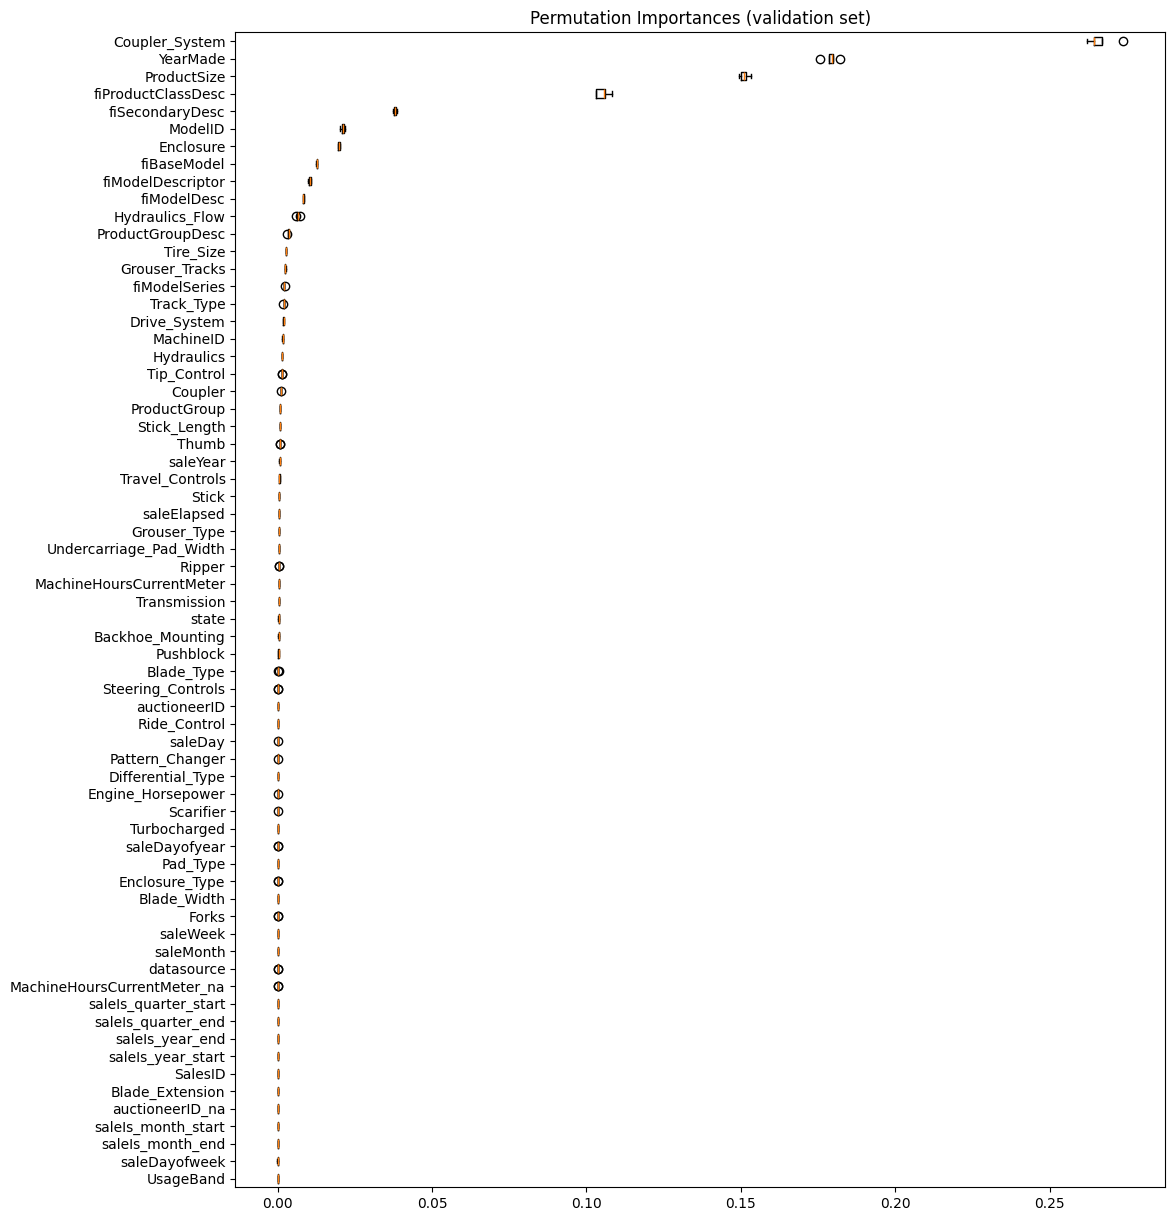

In [10]:
plot_importances(
    importances, sorted_idx, X_valid, "Permutation Importances (validation set)"
)

## Remove Redundant Features

In [11]:
df_reduced = remove_redundant_features(df)
X_train_reduced, X_valid_reduced = split_vals(df_reduced, n_train)

model.fit(X_train_reduced, y_train)

/home/jiaokan/Machine Learning in Practice/.venv/lib/python3.11/site-packages/sklearn/cluster/_agglomerative.py:586: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  out = hierarchy.linkage(X, method=linkage, metric=affinity)


CPU times: user 2 μs, sys: 2 μs, total: 4 μs
Wall time: 9.06 μs


RandomForestRegressor()

In [12]:
print_score(model, X_train_reduced, y_train, X_valid_reduced, y_valid)

RMSE on train set: 0.1970
RMSE on valid set: 0.2366
R^2 on train set: 0.9189
R^2 on valid set: 0.9000


In [13]:
baseline_predictions = model.predict(X_valid_reduced)
baseline_mse = mean_squared_error(y_valid, baseline_predictions)

importances_mean, importances = permutation_importance(
    model, X_valid_reduced, y_valid, baseline_mse
)

sorted_idx = cp.argsort(importances_mean)

Computing importances:   0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

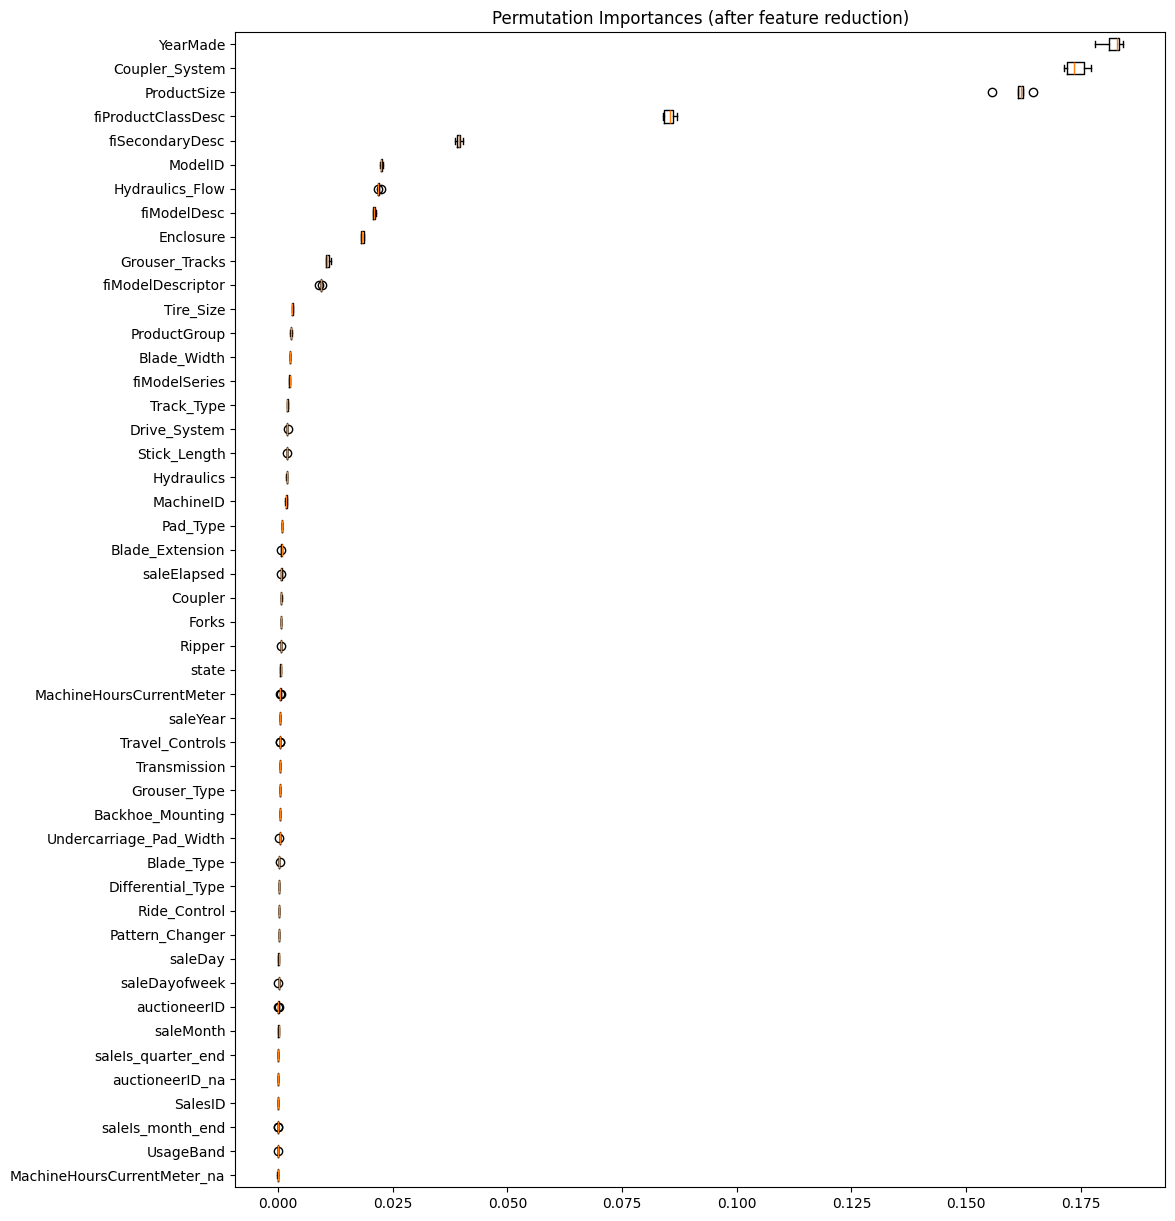

In [14]:
plot_importances(
    importances, sorted_idx, X_valid_reduced, "Permutation Importances (after feature reduction)"
)

## Remove Low Importance Features

In [15]:
bool_filter = importances_mean > np.percentile(importances_mean, 30)
to_keep = df_reduced.columns[bool_filter]

df_keep = df_reduced[to_keep].copy()

X_train_keep, X_valid_keep = split_vals(df_keep, n_train)
y_train, y_valid = split_vals(y, n_train)

df_keep

,MachineID,ModelID,YearMade,MachineHoursCurrentMeter,fiModelDesc,fiSecondaryDesc,fiModelSeries,fiModelDescriptor,ProductSize,fiProductClassDesc,...,Coupler_System,Grouser_Tracks,Hydraulics_Flow,Track_Type,Stick_Length,Grouser_Type,Backhoe_Mounting,Travel_Controls,saleYear,saleElapsed
0,999089.0,3157.0,2004.0,68.0,950.0,41.0,0.0,0.0,0.0,59.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2006.0,1.163635e+09
1,117657.0,77.0,1996.0,4640.0,1725.0,55.0,98.0,0.0,4.0,62.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2004.0,1.080259e+09
2,434808.0,7009.0,2001.0,2838.0,331.0,0.0,0.0,0.0,0.0,39.0,...,1.0,1.0,3.0,0.0,0.0,0.0,0.0,0.0,2004.0,1.077754e+09
3,1026470.0,332.0,2001.0,3486.0,3674.0,0.0,45.0,0.0,6.0,8.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2011.0,1.305763e+09
4,1057373.0,17311.0,2007.0,722.0,4208.0,0.0,0.0,0.0,0.0,40.0,...,1.0,1.0,3.0,0.0,0.0,0.0,0.0,0.0,2009.0,1.248307e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
401120,1840702.0,21439.0,2005.0,0.0,657.0,106.0,63.0,0.0,5.0,17.0,...,0.0,0.0,0.0,2.0,29.0,1.0,0.0,0.0,2011.0,1.320192e+09
401121,1830472.0,21439.0,2005.0,0.0,657.0,106.0,63.0,0.0,5.0,17.0,...,0.0,0.0,0.0,2.0,29.0,1.0,0.0,0.0,2011.0,1.320192e+09
401122,1887659.0,21439.0,2005.0,0.0,657.0,106.0,63.0,0.0,5.0,17.0,...,0.0,0.0,0.0,2.0,29.0,1.0,0.0,0.0,2011.0,1.320192e+09
401123,1903570.0,21435.0,2005.0,0.0,483.0,106.0,0.0,0.0,5.0,13.0,...,0.0,0.0,0.0,2.0,29.0,1.0,0.0,0.0,2011.0,1.319501e+09


In [16]:
model = RandomForestRegressor(
    n_estimators = 60,
    max_depth = 45,
    min_samples_split = 10,
    max_features = 0.51,
    random_state = 42,
    bootstrap = True,
    max_samples = 0.75,
    n_streams = 1
)

%time
model.fit(X_train_keep, y_train)

CPU times: user 3 μs, sys: 2 μs, total: 5 μs
Wall time: 10 μs


RandomForestRegressor()

In [17]:
print_score(model, X_train_keep, y_train, X_valid_keep, y_valid)

RMSE on train set: 0.1424
RMSE on valid set: 0.2245
R^2 on train set: 0.9576
R^2 on valid set: 0.9100


In [18]:
baseline_predictions = model.predict(X_valid_keep)
baseline_mse = mean_squared_error(y_valid, baseline_predictions)

importances_mean, importances = permutation_importance(
    model, X_valid_keep, y_valid, baseline_mse
)

sorted_idx = cp.argsort(importances_mean)

Computing importances:   0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

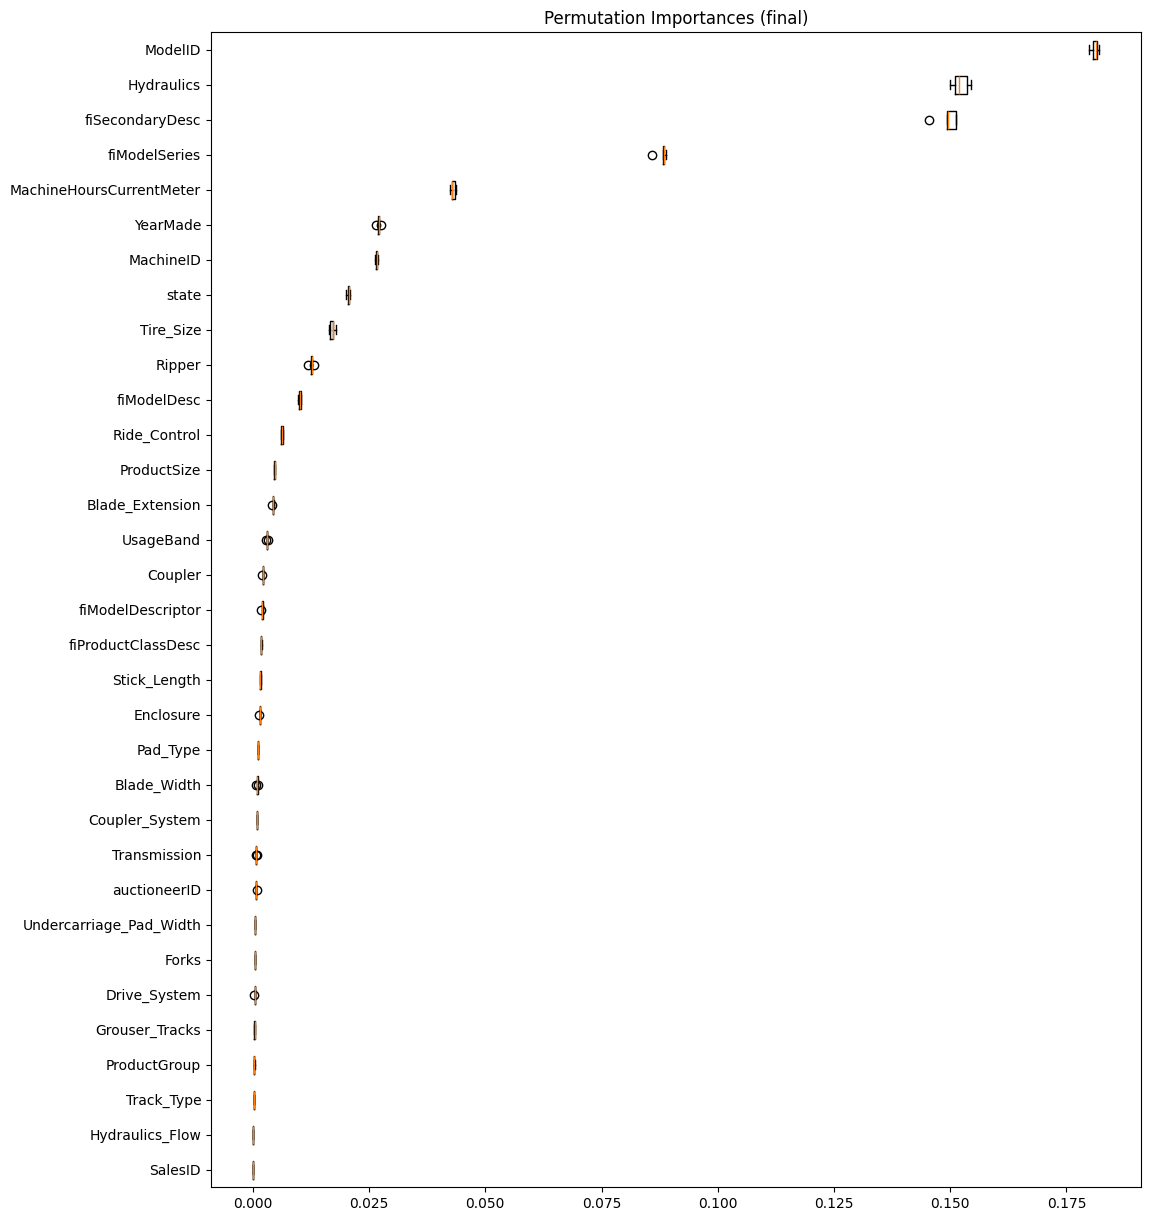

In [19]:
plot_importances(
    importances, sorted_idx, X_valid_reduced, "Permutation Importances (final)"
)